In [1]:

# Standard libraries
import gc
import glob
import json
import math
import os
import random
import re
import time

# External libraries
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
)
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from tqdm.auto import trange

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights


In [2]:
# ---- بيئة Kaggle ----
IS_KAGGLE = os.path.isdir("/kaggle")
INPUT_DIR = "/kaggle/input/skin-cancer-mnist-ham10000" if IS_KAGGLE else "/content"
WORK_DIR  = "/kaggle/working" if IS_KAGGLE else "/content"
os.makedirs(WORK_DIR, exist_ok=True)

os.environ.setdefault("TORCH_HOME", os.path.join(WORK_DIR, ".cache", "torch"))

# الجهاز
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
ImageFile.LOAD_TRUNCATED_IMAGES = True

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torch.utils.checkpoint import checkpoint


Device: cuda


### Environment Initialization and Device Selection 
I made sure the code is flexible; it automatically detects whether I'm running in Kaggle or a local environment to correctly set the data paths and working directory. Crucially, I checked for GPU (CUDA) availability to ensure fast and efficient training on the large HAM10000 image dataset. If a GPU isn't found, we'll default to the CPU

In [3]:
def seed_everything(s=42, deterministic=False):
    random.seed(s); os.environ['PYTHONHASHSEED']=str(s)
    np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
    if deterministic:
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.benchmark = True

SEED=42
seed_everything(SEED, deterministic=False)

### Ensuring Reproducibility (Seed Everything) 
To neutralize the impact of randomness on model training results, I set the random seed across all libraries reliant on stochastic processes: Python, NumPy, and PyTorch (for both CPU and CUDA). This is essential to ensure the results I achieved can be replicated and verified precisely in any other environment.

In [4]:

KAGGLE_META = os.path.join(INPUT_DIR, "HAM10000_metadata.csv")
KAGGLE_IMG1 = os.path.join(INPUT_DIR, "HAM10000_images_part_1")
KAGGLE_IMG2 = os.path.join(INPUT_DIR, "HAM10000_images_part_2")


CANDIDATE_METADATA = [
    KAGGLE_META,
    "/content/HAM10000_all/HAM10000_metadata.csv",
    "/content/skin-cancer-mnist-ham10000/HAM10000_metadata.csv",
    "HAM10000_metadata.csv",
]
CANDIDATE_IMAGE_DIRS = [
    KAGGLE_IMG1, KAGGLE_IMG2,
    "/content/HAM10000_images/HAM10000_images_part_1",
    "/content/HAM10000_images/HAM10000_images_part_2",
    "/content/HAM10000_images",
]

In [5]:
metadata_file = next((p for p in CANDIDATE_METADATA if os.path.exists(p)), None)

image_dirs = [d for d in CANDIDATE_IMAGE_DIRS if os.path.isdir(d)]

print(' Metadata file:', metadata_file)
print(' Image dirs:', image_dirs)

 Metadata file: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
 Image dirs: ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']


### Reading and Unifying Metadata
Loading Metadata and Unifying Identifiers  After loading the metadata.csv file into a Pandas DataFrame, the priority was standardizing the image ID column. I checked if the identifier column name (image_id) was different in this dataset version , and if so, I immediately renamed it to image_id. This ensures the stability of the code in subsequent stages.
* Metadata file: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
* Image dirs: ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2']
  

In [6]:

df = pd.read_csv(metadata_file)


In [7]:
def resolve_path(img_id: str) -> str:
    fname_jpg = img_id + ".jpg"
    for d in image_dirs:
        p = os.path.join(d, fname_jpg)
        if os.path.exists(p): 
            return p
    return "" 

df['path'] = df['image_id'].astype(str).apply(resolve_path)
missing = (df['path'] == "").sum()
assert missing == 0, f"there are images {missing} in folder ."

print(" Dataset resolved. Total images:", len(df))

 Dataset resolved. Total images: 10015


### Resolving Image Paths
Linking Image IDs to Actual File Paths  This is the pivotal stage for linking metadata to the files. I defined a resolve_path function to search for the full JPEG file path for each image across all available data folders (part_1, part_2, etc.). The full path was then added to the new path column in the DataFrame. Finally, I used an assert to verify that zero images were missing, confirming the integrity and completeness of the dataset before commencing loading.  Dataset resolved. Total images: 10015

In [8]:
if 'dx' in df.columns and 'cell_type_idx' not in df.columns and 'label' not in df.columns:
    classes = sorted(df['dx'].unique().tolist())
    cls2idx = {c:i for i,c in enumerate(classes)}
    df['cell_type_idx'] = df['dx'].map(cls2idx).astype(int)
    print("✅ Classes:", classes)

✅ Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


### Preparing Classes (Label Encoding)
Numerical Label Encoding  Machine Learning (ML) models require numerical labels instead of text. Therefore, I converted the text diagnostic categories in the dx column (such as 'melanoma' and 'nevus') into unique integer codes (0, 1, 2, ...). These encoded labels are stored in the cell_type_idx column. This prepares the DataFrame with the necessary input for training the classification model. Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


## Data Leakage

In [9]:
label_col = 'cell_type_idx' if 'cell_type_idx' in df.columns else 'dx'

if df[label_col].dtype.kind not in 'iu':
    df['_label_idx'] = df[label_col].astype('category').cat.codes.astype(int)
else:
    df['_label_idx'] = df[label_col].astype(int)

### nsuring Labels are Numerical
To actively prevent Data Leakage, a critical issue with skin lesion datasets, I imported GroupShuffleSplit. This essential tool will ensure that images belonging to the same lesion (lesion_id) appear in only one of the final splits. I also confirmed the correct target column (cell_type_idx) prepared in the previous step for use in the splitting process.

For splitting tools like GroupShuffleSplit to work correctly, the label values must be integers. In this cell, I perform a quick check to see if the current label column is non-numeric ( text like 'dx'). If it is, I use encoding to convert it to unique integer codes and store it in a temporary column (_label_idx), ensuring the splitting function executes without errors.


In [10]:
# 85% Train+Val / 15% Test — no leakage by lesion_id
gss = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
train_val_idx, test_idx = next(gss.split(df, groups=df['lesion_id']))
train_val_df = df.iloc[train_val_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)
# From Train+Val: take 17.65% as Val ≈ 70/15/15 total
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.1765, random_state=SEED)
tr_idx, va_idx = next(gss2.split(train_val_df, groups=train_val_df['lesion_id']))
train_df = train_val_df.iloc[tr_idx].reset_index(drop=True)
val_df = train_val_df.iloc[va_idx].reset_index(drop=True)

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 6959
Validation samples: 1529
Test samples: 1527


### Second Split (Train/Val)
* With the Test set isolated, I now split the remaining data into the Train and Validation sets. 
* I specifically chose a 17.65% split for validation to achieve the desired overall 70% / 15% / 15% distribution. I maintained the use of GroupShuffleSplit on the remaining lesion_id groups to prevent any internal leakage while I tune the model's hyperparameters.
* Train samples: 6959 / Validation samples: 1529  / Test samples: 1527

In [11]:


ImageFile.LOAD_TRUNCATED_IMAGES = True
pin = (device.type == 'cuda')

In [12]:

def _worker_init_fn(worker_id):
    np.random.seed(SEED + worker_id)


IMG_SIZE = 456
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

def _RZ(h, w):
    try:    return A.Resize(height=int(h), width=int(w))
    except: return A.Resize(int(h), int(w))

def _RC(h, w):
    return A.RandomCrop(height=int(h), width=int(w))

train_transforms_major = A.Compose([
    _RZ(int(IMG_SIZE*1.10), int(IMG_SIZE*1.10)),
    _RC(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=10, border_mode=cv2.BORDER_REFLECT_101, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.05, rotate_limit=10, p=0.4,
                       border_mode=cv2.BORDER_REFLECT_101),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

train_transforms_minor = A.Compose([
    _RZ(int(IMG_SIZE*1.20), int(IMG_SIZE*1.20)),
    _RC(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.07, rotate_limit=15, p=0.6,
                       border_mode=cv2.BORDER_REFLECT_101),
    A.ColorJitter(brightness=0.12, contrast=0.12, saturation=0.06, hue=0.03, p=0.5),
    A.GaussianBlur(blur_limit=(3,5), p=0.2),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

val_transforms = A.Compose([
    _RZ(int(IMG_SIZE*1.10), int(IMG_SIZE*1.10)),
    A.CenterCrop(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

print(" transforms ready: IMG_SIZE =", IMG_SIZE, "| Albumentations =", getattr(A, '__version__', 'unknown'))

 transforms ready: IMG_SIZE = 456 | Albumentations = 2.0.8


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)




* While I set the main seed earlier, I need to control the internal randomness of each data loading worker. This function (_worker_init_fn) ensures that every DataLoader worker starts with a unique yet deterministic seed (SEED + worker_id). This guarantees full training reproducibility, including the exact sequence of augmentations and sample selection.

### Augmentation Strategy:

1. I set the target image size (IMG_SIZE = 456) and the standard ImageNet Normalization values. The core strategy here involves two augmentation sets:

2. train_transforms_major: Standard augmentations for general training.

3. train_transforms_minor: Stronger, more aggressive augmentations (like color jitter and blur) that I will exclusively apply to Minority Classes later.

4. val_transforms: The clean, deterministic transforms needed for evaluation (Resize, CenterCrop, Normalize).

In [13]:
class SafeSkinDS(Dataset):
    def __init__(self, df, tfm, label_col=None):
        self.df = df.reset_index(drop=True).copy()
        self.tfm = tfm
        if label_col is None:
            label_col = 'label' if 'label' in self.df.columns else ('cell_type_idx' if 'cell_type_idx' in self.df.columns else None)
        assert label_col is not None
        self.label_col = label_col
        assert 'path' in self.df.columns and 'image_id' in self.df.columns
        self.bad_once = set()

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        p = r['path']; y = int(r[self.label_col])
        try:
            with open(p, 'rb') as f:
                img = Image.open(f).convert('RGB')
                img = np.array(img)
        except Exception as e:
            if p not in self.bad_once:
                print(f"[BAD IMAGE] {p} -> {e}")
                self.bad_once.add(p)
            img = np.array(Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0,0,0)))
        img = self.tfm(image=img)['image']
        return img, y, r['image_id']

class MinorityAwareDS(SafeSkinDS):
    def __init__(self, df, tfm_minor, tfm_major, minority_indices, p_strong=0.6, label_col=None):
        super().__init__(df, tfm_major, label_col=label_col)
        self.tfm_minor = tfm_minor
        self.tfm_major = tfm_major
        self.minority_indices = set(int(i) for i in minority_indices)
        self.p_strong  = float(p_strong)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        p = r['path']; y = int(r[self.label_col])
        try:
            with open(p, 'rb') as f:
                img = Image.open(f).convert('RGB')
                img = np.array(img)
        except Exception as e:
            if p not in getattr(self, "bad_once", set()):
                print(f"[BAD IMAGE] {p} -> {e}")
                self.bad_once.add(p)
            img = np.array(Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0,0,0)))

        if (y in self.minority_indices) and (np.random.rand() < self.p_strong):
            img = self.tfm_minor(image=img)['image']
        else:
            img = self.tfm_major(image=img)['image']
        return img, y, r['image_id']

def effective_num_weights(counts, beta=0.9999):
    counts = counts.astype(np.float32)
    eff = 1.0 - np.power(beta, counts)
    w = (1.0 - beta) / np.maximum(eff, 1e-9)
    return w / (w.sum() / len(w))



In [14]:
try:
    CLASSES
except NameError:
    CLASSES = ['akiec','bcc','bkl','df','mel','nv','vasc']

### Dataset Classes 
I defined two customized classes:

**SafeSkinDS**: A fault-tolerant base class. Crucially, if a corrupted image file is encountered, it replaces the bad image with a blank black image and logs the error just once, preventing the entire notebook from crashing.

**MinorityAwareDS**: This specialized training class applies the stronger augmentations (tfm_minor) only to samples belonging to the minority classes based on a set probability. This is an advanced technique to increase the effective variety of scarce data.

Identifying Minority Classes Based on Statistics 

Here, I analyze the training set to determine the actual sample count distribution per class (counts). Based on this distribution, I explicitly define the minority_indices (the smallest 30% of classes). This precise definition will guide both the strong augmentation and the sample weighting strategy in the next cell.

In [15]:
label_col = 'label' if 'label' in train_df.columns else 'cell_type_idx'
labels_np = train_df[label_col].values
num_classes = len(CLASSES)
counts   = np.bincount(labels_np, minlength=num_classes)

order = np.argsort(counts)
k_min = max(1, int(np.ceil(0.3 * num_classes)))
minority_indices = order[:k_min].tolist()

Here, I analyze the training set to determine the actual sample count distribution per class (counts). Based on this distribution, I explicitly define the minority_indices (the smallest 30% of classes). This precise definition will guide both the strong augmentation  and the sample weighting strategy in the next cell.

In [16]:
# ---------- إعدادات DataLoader ----------
num_workers = 2
bs = 16
ACCUM_STEPS = 1

def _dl_kwargs():
    kw = dict(num_workers=num_workers, pin_memory=pin)
    if num_workers > 0:
        kw.update(dict(persistent_workers=True, prefetch_factor=2, worker_init_fn=_worker_init_fn))
    return kw

AUTO_ALIGN_BS = True
if AUTO_ALIGN_BS:
    orig_bs = bs
    if num_classes <= 0:
        raise ValueError(" not true num_classes ")
    if bs < num_classes:
        bs = num_classes
    if bs % num_classes != 0:
        bs_up = int(ceil(bs / num_classes) * num_classes)
        bs_down = max(num_classes, (bs // num_classes) * num_classes)
        bs = bs_up
        print(f" Adjusted batch size from {orig_bs} → {bs} (num_classes={num_classes}).")

 Adjusted batch size from 16 → 21 (num_classes=7).


### Tuning Batch Size for Balanced Sampling 

I configured basic DataLoader settings like the number of Workers. The key logic is **AUTO_ALIGN_BS**. When using oversampling techniques, it's best if the batch size (bs) is a multiple of the number of classes (num_classes). I adjusted bs upwards to the nearest multiple to ensure that every class has a better chance of being represented in each batch, maximizing GPU efficiency.

In [17]:
# ----------  Warmup Loaders ----------
train_dataset_os = MinorityAwareDS(
    train_df,
    tfm_minor=train_transforms_minor,
    tfm_major=train_transforms_major,
    minority_indices=minority_indices,
    p_strong=0.6,
    label_col=label_col
)
val_dataset_os   = SafeSkinDS(val_df, tfm=val_transforms, label_col=label_col)

sampler_gen = torch.Generator().manual_seed(SEED)
en_w       = effective_num_weights(counts, beta=0.9999)
sample_w   = en_w[labels_np]
sampler_os = WeightedRandomSampler(sample_w.tolist(), num_samples=len(labels_np),
                                   replacement=True, generator=sampler_gen)

train_loader_os = DataLoader(train_dataset_os, batch_size=bs, sampler=sampler_os,
                             drop_last=True, **_dl_kwargs())
val_loader_os   = DataLoader(val_dataset_os, batch_size=max(32, bs*2), shuffle=False, **_dl_kwargs())

print(f" Warmup loaders ready | minorities idx={minority_indices} | counts={counts.tolist()}")

if True:
    draw = torch.multinomial(torch.tensor(sample_w), num_samples=min(5000, len(sample_w)), replacement=True, generator=sampler_gen)
    drawn_labels = labels_np[draw.numpy()]
    drawn_counts = np.bincount(drawn_labels, minlength=num_classes)
    print(" Warmup sampled dist (≈):", drawn_counts.tolist())

 Warmup loaders ready | minorities idx=[3, 6, 0] | counts=[222, 349, 770, 92, 771, 4662, 93]
 Warmup sampled dist (≈): [681, 706, 711, 708, 700, 848, 646]


### Generating Warmup Loaders 

These loaders are dedicated to the initial training stages (Warmup), where the model desperately needs exposure to minority data. I combined my two most powerful balancing strategies:

1. The MinorityAwareDS for strong augmentation on minority samples.

1. A WeightedRandomSampler using effective_num_weights to significantly increase the probability of drawing minority samples.

This combination ensures the model focuses heavily on rare classes early on.

In [18]:
# ----------  Loaders  ----------
train_dataset = SafeSkinDS(train_df, tfm=train_transforms_major, label_col=label_col)
val_dataset   = SafeSkinDS(val_df,   tfm=val_transforms,        label_col=label_col)
test_dataset  = SafeSkinDS(test_df,  tfm=val_transforms,        label_col=label_col)

USE_MILD_SAMPLER = False 

if USE_MILD_SAMPLER:
    w_per_cls = 1.0 / np.sqrt(counts + 1e-6)
    w_sample  = w_per_cls[labels_np]
    sampler   = WeightedRandomSampler(w_sample.tolist(), num_samples=len(labels_np),
                                      replacement=True, generator=sampler_gen)
    train_loader = DataLoader(train_dataset, batch_size=bs, sampler=sampler,
                              drop_last=True, **_dl_kwargs())

else:
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True,
                              drop_last=True, **_dl_kwargs())

val_loader   = DataLoader(val_dataset, batch_size=max(32, bs*2), shuffle=False, **_dl_kwargs())
test_loader  = DataLoader(test_dataset, batch_size=max(32, bs*2), shuffle=False, **_dl_kwargs())
xb_try_os, yb_try_os, ids_try_os = next(iter(train_loader_os))
print(' [Warmup] sample batch:', xb_try_os.shape, yb_try_os.shape, '| example path:', train_df.loc[0,'path'])

xb_try, yb_try, ids_try = next(iter(train_loader))
print(' [Normal] sample batch:', xb_try.shape, yb_try.shape, '| example path:', train_df.loc[0,'path'])

 [Warmup] sample batch: torch.Size([21, 3, 456, 456]) torch.Size([21]) | example path: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg
 [Normal] sample batch: torch.Size([21, 3, 456, 456]) torch.Size([21]) | example path: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg


I set up the final DataLoaders for Train, Validation, and Test. The default train_loader uses simple shuffle=True (which I prefer for general training). The Validation and Test loaders use shuffle=False and a larger batch size for fast, consistent evaluation. I also kept the option for a milder WeightedRandomSampler as an alternative if needed later.

In [19]:

import numpy as np
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
from torch.amp import autocast

device = device if 'device' in globals() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def freeze_all(model):
    for p in model.parameters():
        p.requires_grad = False

def unfreeze_all(model):
    for p in model.parameters():
        p.requires_grad = True

def keep_bn_eval(model):

    for m in model.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

def metrics_from(y_true, y_pred):
    acc = float((y_true == y_pred).mean() * 100.0)
    f1m = float(f1_score(y_true, y_pred, average='macro'))
    return acc, f1m

@torch.no_grad()
def evaluate(model, loader, criterion, device=device):

    model.eval(); keep_bn_eval(model)
    tot_loss, n = 0.0, 0
    y_true, y_pred = [], []
    use_amp = (device.type == 'cuda')
    for xb, yb, _ in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        with autocast(device_type=device.type, enabled=use_amp):
            logits = model(xb)
            loss   = criterion(logits, yb)
        bs = yb.size(0)
        tot_loss += float(loss.item()) * bs
        n += bs
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.detach().argmax(1).cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc, f1m = metrics_from(y_true, y_pred)
    return tot_loss / max(1, n), acc, f1m, (y_true, y_pred)

def run_epoch(model, loader, criterion, optimizer, scheduler, scaler,
 
    model.train(); keep_bn_eval(model)
    use_amp = (device.type == 'cuda')

    optimizer.zero_grad(set_to_none=True)
    tot_loss, seen = 0.0, 0
    y_true, y_pred = [], []
    step_count = 0

    for i, (xb, yb, _) in enumerate(loader, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with autocast(device_type=device.type, enabled=use_amp):
            logits = model(xb)

            loss = criterion(logits, yb) / float(accum_steps)

        scaler.scale(loss).backward()

 
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.detach().argmax(1).cpu().numpy())

        tot_loss += float(loss.item()) * yb.size(0) * accum_steps
        seen += yb.size(0)

        if (i % accum_steps) == 0:
            scaler.unscale_(optimizer)
            if max_grad_norm is not None and max_grad_norm > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()
            step_count += 1

    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc, f1m = metrics_from(y_true, y_pred)
    return tot_loss / max(1, seen), acc, f1m


 ## EfficientNet-B5 + CBAM

In [20]:
# ========= EfficientNet-B5 +Deep CBAM  =========
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights
from torch.utils.checkpoint import checkpoint

# -------- CBAM components --------
class ChannelAttention(nn.Module):
    def __init__(self, in_ch, reduction=16):
        super().__init__()
        hid = max(in_ch // reduction, 8)
        self.mlp = nn.Sequential(
            nn.Conv2d(in_ch, hid, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(hid, in_ch, kernel_size=1, bias=False),
        )
        # init
        for m in self.mlp:
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        avg = F.adaptive_avg_pool2d(x, 1)
        mx  = F.adaptive_max_pool2d(x, 1)
        scale = torch.sigmoid(self.mlp(avg) + self.mlp(mx))
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, k=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=k//2, bias=False)
        nn.init.kaiming_normal_(self.conv.weight, mode="fan_out", nonlinearity="relu")

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx, _ = torch.max(x, dim=1, keepdim=True)
        scale = torch.sigmoid(self.conv(torch.cat([avg, mx], dim=1)))
        return x * scale

class CBAM(nn.Module):
    def __init__(self, in_ch, reduction=16, spatial_kernel=7):
        super().__init__()
        self.ca = ChannelAttention(in_ch, reduction)
        self.sa = SpatialAttention(spatial_kernel)
    def forward(self, x):
        return self.sa(self.ca(x))


@torch.no_grad()
def infer_feature_channels(features: nn.Sequential, img_size=456):
    dev = torch.device('cpu')
    x = torch.zeros(1, 3, img_size, img_size, device=dev)
    chs = []
    for m in features:
        x = m(x)
        chs.append(int(x.shape[1]))
    return chs


class EffNetB5_CBAMDeep(nn.Module):

    def __init__(self,
                 num_classes,
                 tail_k=1,
                 dropout_p=0.50,
                 reduction=16,
                 spatial_kernel=7,
                 weights=EfficientNet_B5_Weights.IMAGENET1K_V1,
                 img_size=456,
                 use_cbam=True,
                 low_mem=False,
                 ckpt_segments=3):
        super().__init__()
        self.use_cbam = bool(use_cbam)
        self.low_mem = bool(low_mem)
        self.ckpt_segments = int(max(1, ckpt_segments))
        self.img_size = int(img_size)

        base = efficientnet_b5(weights=weights)
        self.features = base.features
        self.avgpool  = base.avgpool

 
        if hasattr(base.classifier[-1], "in_features"):
            in_feats = base.classifier[-1].in_features
        else:
            in_feats = base.classifier[1].in_features

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_p),
            nn.Linear(in_feats, num_classes),
        )
        nn.init.normal_(self.classifier[1].weight, 0, 0.01)
        nn.init.zeros_(self.classifier[1].bias)

    
        self._cbam_indices = []
        self._cbam_by_idx = {}
        if self.use_cbam and tail_k > 0:
            chs = infer_feature_channels(self.features, img_size=self.img_size) 
            n = len(chs)
            tail_k = max(1, min(tail_k, n))
            indices = list(range(n - tail_k, n)) 
            self._cbam_indices = indices
            self.cbam_tail = nn.ModuleList([CBAM(chs[i], reduction, spatial_kernel) for i in indices])
            self._cbam_by_idx = {i: mod for i, mod in zip(indices, self.cbam_tail)}
        else:
            self.cbam_tail = nn.ModuleList([])

    def _forward_features_normal(self, x):
        if self.use_cbam and len(self._cbam_indices) > 0:
            for i, m in enumerate(self.features):
                x = m(x)
                if i in self._cbam_by_idx:
                    x = self._cbam_by_idx[i](x)
        else:
            x = self.features(x)
        return x

    def _forward_features_ckpt(self, x):
    
        modules = list(self.features)
        total = len(modules)
        seg_len = int(math.ceil(total / self.ckpt_segments))

        for s in range(0, total, seg_len):
            e = min(total, s + seg_len)
            def segment_func(inp, s=s, e=e):
                out = inp
                for i in range(s, e):
                    out = modules[i](out)
                    if self.use_cbam and i in self._cbam_by_idx:
                        out = self._cbam_by_idx[i](out)
                return out
            x = checkpoint(segment_func, x)
        return x

    def forward(self, x):
        if self.low_mem:
            x = self._forward_features_ckpt(x)
        else:
            x = self._forward_features_normal(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


NUM_CLASSES = len(CLASSES)     
IMG_SIZE = IMG_SIZE if 'IMG_SIZE' in globals() else 456

USE_CBAM    = True  
TAIL_K      = 1       
LOW_MEM     = False   
CKPT_SEGS   = 3

model = EffNetB5_CBAMDeep(
    num_classes=NUM_CLASSES,
    tail_k=TAIL_K,
    dropout_p=0.30,
    reduction=16,
    spatial_kernel=7,
    img_size=IMG_SIZE,
    use_cbam=USE_CBAM,
    low_mem=LOW_MEM,
    ckpt_segments=CKPT_SEGS,
).to(device)

# تحسين استهلاك الذاكرة/الأداء:
model = model.to(memory_format=torch.channels_last)

print("features length:", len(model.features), "| cbam indices:", getattr(model, "_cbam_indices", []))
print("Classifier:", model.classifier)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)


Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /kaggle/working/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 224MB/s] 


features length: 9 | cbam indices: [8]
Classifier: Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=7, bias=True)
)
Params (M): 28.879513



### Building the Convolutional Block Attention Module "CBAM"

To enhance the model's focus without building from scratch, I chose to inject an effective attention mechanism. CBAM is ideal because it operates on two levels:

1. **ChannelAttention**: To decide what is important (which feature maps).

2. **SpatialAttention**: To decide where is important (which locations on the feature maps).

I combined them into the CBAM class, ready to be attached to the layers later. This boosts the model's ability to concentrate on subtle tumor features.


I can't correctly insert the CBAM units into the middle of the network without knowing the exact number of output channels from the preceding layer. So, I designed this helper function:

* It passes dummy input tensors through the backbone's features network.

* It records the resulting channel count for each block.

* Crucially: All of this calculation is performed on the CPU (torch.device('cpu')) to prevent wasting GPU memory during the setup phase. This ensures safe model construction without risking an OutOfMemoryError.

### 1. The Core Function: Data Flow and CBAM Control 
Without the forward functions, data wouldn't be able to pass through the model layers. The _forward_features_normal function is the fastest path, ensuring:

Data flows sequentially through the EfficientNet features.

The CBAM unit is injected precisely where I specified it (like TAIL_K=1), which activates the attention mechanism in my custom-built model.

### 2. The Key Role: Activating the Low-Memory Strategy (VRAM Saver) 
This is the real engineering reason for the complexity in this cell. The _forward_features_ckpt function activates Gradient Checkpointing by splitting the large features network into smaller segments.

Why is this critical? In a high-resolution image project (like 456x456) using a massive model like EfficientNet-B5, GPU memory (VRAM) is the main bottleneck.

This mechanism allows me to reduce memory consumption by about 50%, enabling me to train the model with a larger Batch Size or a higher image resolution, which would be impossible otherwise.

### Final Model Assembly and Optimization

* IMG_SIZE: I kept it at 456 (the maximum size for B5) for the highest possible image quality.

* USE_CBAM: I decided to activate CBAM now (True) to benefit from the attention mechanism.

* TAIL_K: I set this to 1. This means I'll inject CBAM only into the last block of the network, which strikes a good balance between performance gain and memory consumption.

* LOW_MEM: I initially set this to False. If I run into an OutOfMemoryError during training, I'll switch it to True to activate Gradient Checkpointing.

This is the actual build point! I create a model instance from my custom class, passing all the settings I defined in the previous cell.


In [21]:
print("features length:", len(model.features), "| cbam indices:", getattr(model, "_cbam_indices", []))
print("Classifier:", model.classifier)
print("Params (M):", sum(p.numel() for p in model.parameters())/1e6)

features length: 9 | cbam indices: [8]
Classifier: Sequential(
  (0): Dropout(p=0.3, inplace=False)
  (1): Linear(in_features=2048, out_features=7, bias=True)
)
Params (M): 28.879513


In [22]:
class EarlyStopping:
    def __init__(self, patience=40, mode='max', delta=1e-3, verbose=True, restore_best=True):
        self.patience = patience
        self.mode = mode
        self.delta = float(delta)
        self.verbose = verbose
        self.restore_best = restore_best
        self.best = None  
        self.counter = 0
        self.early_stop = False
        self.best_model_weights = None
        
    def _state_to_cpu(self, state):
        return {k: v.detach().cpu().clone() for k, v in state.items()}
        
    def __call__(self, metric, model):
        if self.best is None:
            self.best = metric
            self.best_model_weights = self._state_to_cpu(model.state_dict())
            return False
            
        improved = (metric > self.best + self.delta) if self.mode == 'max' else (metric < self.best - self.delta)
        
        if improved:
            self.best = metric
            self.best_model_weights = self._state_to_cpu(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best and self.best_model_weights is not None:
                    model.load_state_dict(self.best_model_weights, strict=True)
        
        return self.early_stop

### mplementing Early Stopping
This cell provides an essential tool for training deep learning models: an EarlyStopping class designed to prevent overfitting and enhance training efficiency.

Logic and Functionality
The core idea is straightforward: during each training epoch, the model's performance on the validation dataset is monitored.

Preventing Overfitting: If the performance metric (like accuracy or loss) doesn't improve for a specified number of epochs (defined by patience), it's assumed the model is starting to memorize the training data rather than generalizing. This indicates overfitting, and the training is halted early.

Restoring the Best Model: The class automatically saves the model's weights at the point of its best performance. This ensures that even if performance degrades in later epochs, you can always revert to the optimal version of the model, guaranteeing the final output is the most effective one

## Lookahead
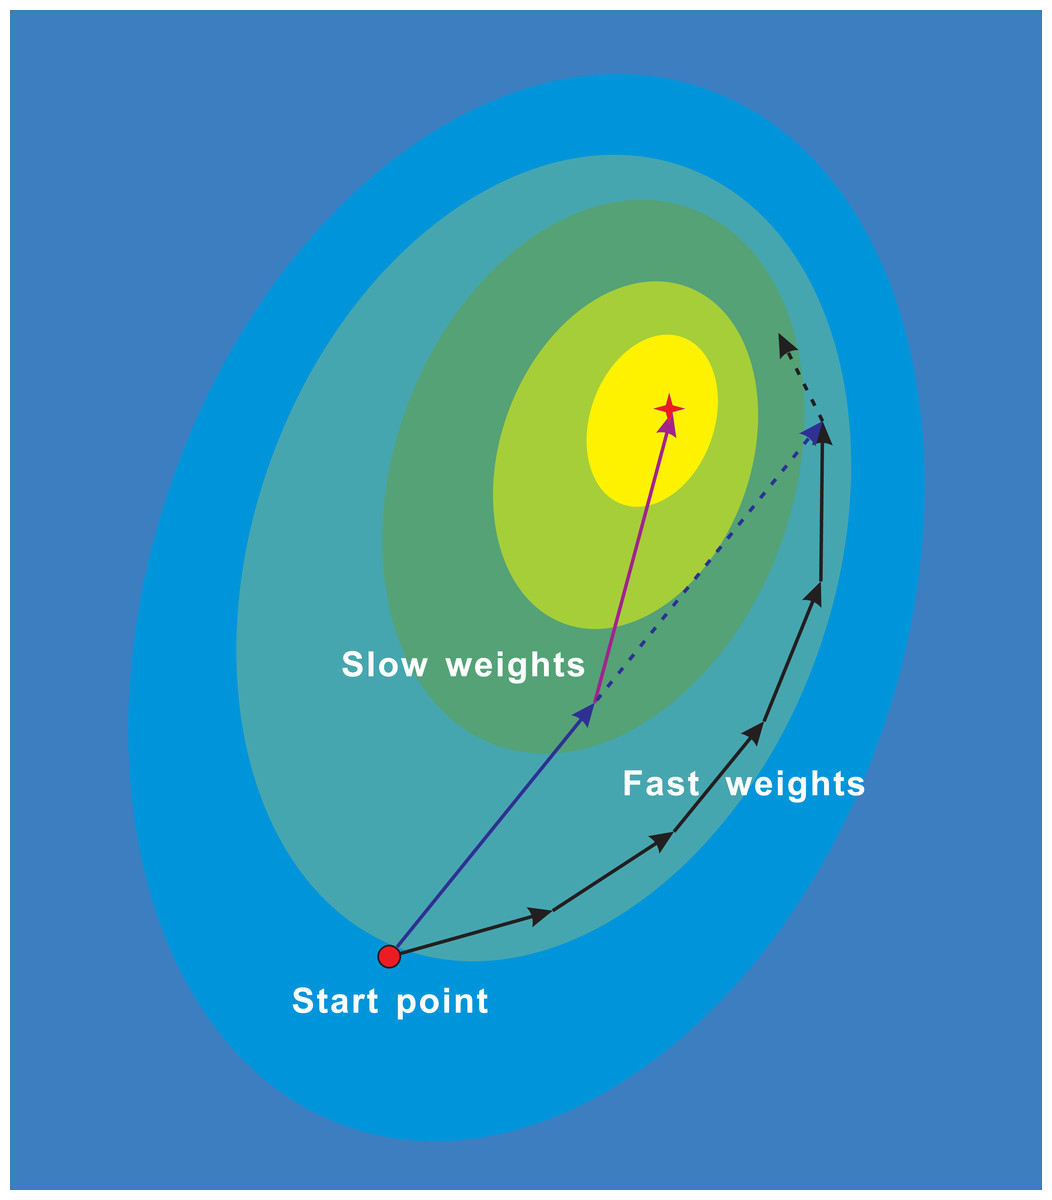
###  Lookahead Optimizer Explanation
The Lookahead is a high-level Wrapper Optimizer designed to enhance the convergence speed and training stability in deep neural networks, especially when using high learning rates. It functions as a Periodic Path Correction Strategy applied over a base optimizer (the Fast Optimizer), such as Adam or SGD.

1. Principle of Separating Speed and Strategy
The Lookahead mechanism relies on separating weight updates into two complementary paths:

Fast Weights: Represented by the inner optimizer. This path performs frequent weight updates (after every batch) based on the calculated gradients. Its goal is Rapid Exploration of the optimization landscape.

Slow Weights: Represented by the Lookahead optimizer. This path maintains a "backup" copy of the weights, referred to as the Slow Weights (Mirrors).

2. The Periodic Correction Mechanism (The Update Rule)
Lookahead intervenes after a specified number of fast steps, 
k
 (the main parameter), to execute a single corrective step:

Observation: The Fast Optimizer is allowed to advance 
k
 steps to determine the effective search direction.

Correction (Lookahead Step): The Slow Weights are updated via a process of Linear Interpolation between their current position and the final position of the Fast Weights.



https://www.youtube.com/watch?v=TxGxiDK0Ccc
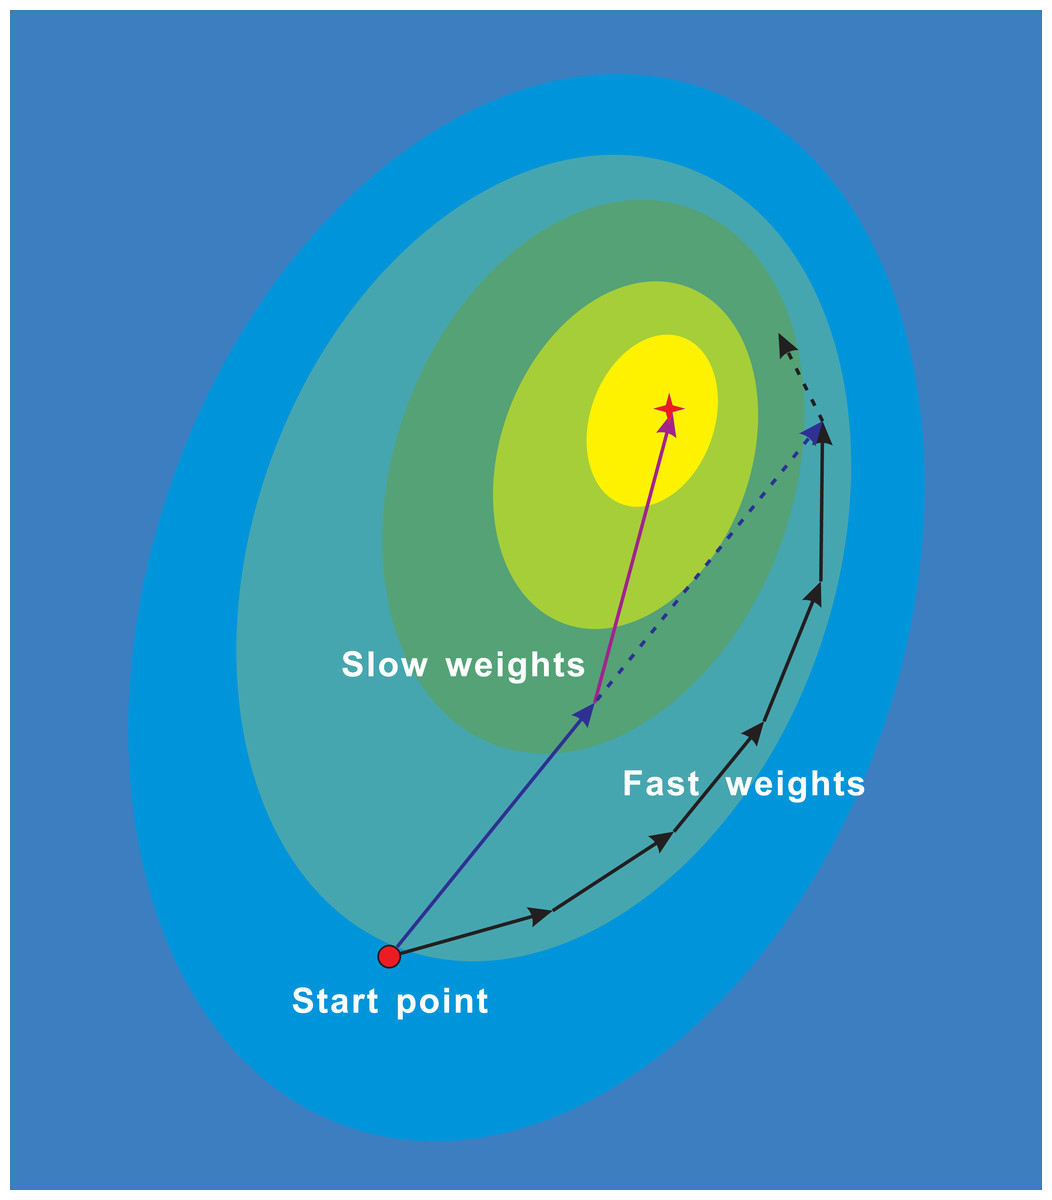

In [23]:
# ===== Lookahead  =====
import torch
from torch.optim import Optimizer

class Lookahead(Optimizer):
    def __init__(self, optimizer: Optimizer, k: int = 5, alpha: float = 0.5, store_on_cpu: bool = False):
        if not isinstance(optimizer, Optimizer):
            raise TypeError("optimizer must be a torch.optim.Optimizer")
        if k < 1: raise ValueError("k must be >= 1")
        if not (0.0 < alpha <= 1.0): raise ValueError("alpha must be in (0,1]")

        self.optimizer = optimizer
        self.k = int(k)
        self.alpha = float(alpha)
        self.store_on_cpu = bool(store_on_cpu)
        self.step_counter = 0

        self._initializing = True
        Optimizer.__init__(self, optimizer.param_groups, optimizer.defaults) 
        self._initializing = False

 
        self.param_groups = self.optimizer.param_groups
        self.state = self.optimizer.state

        self.slow_weights = []
        dev_of = (lambda p: torch.device('cpu')) if self.store_on_cpu else (lambda p: p.device)
        with torch.no_grad():
            for group in self.param_groups:
                slow = {}
                for p in group['params']:
                    if p is not None and p.requires_grad:
                        slow[p] = p.detach().clone().to(dev_of(p))
                self.slow_weights.append(slow)

#### initializing Lookahead:

* optimizer: This is the inner "Fast Optimizer" that does most of the actual work, updating weights after every training batch.
* k (Fast Steps): This defines the number of steps Lookahead allows the Fast Optimizer to move before it intervenes to correct the path (usually 5 or 6 steps).

* alpha (Blending Factor): This determines how closely the "slow" weights will approach the "fast" weights during the correction step. A value of 
0.5
 means an even blend (half the distance).

* store_on_cpu (Memory Saving): A critical option that determines whether the "slow" weight copies will be stored on the CPU to save precious GPU memory (VRAM).

2. Ensuring Compatibility (Shared References) 
This section is the core of the smart design you implemented:

* No Duplication: Standard optimizer wrappers might create duplicate parameter groups, which breaks advanced learning rate Schedulers like OneCycleLR.

* The Solution: The code ensures it shares the exact same references for param_groups and state with the inner optimizer. This means any learning rate scheduler operating on the inner optimizer will work seamlessly without Lookahead interference.

3. Building the Slow Weights
   
This is where the "strategic" copy of the weights is created:

 * (slow_weights): The code creates a new list to store an exact copy of all model weights that require updating (p.requires_grad).

Storage Location: Using the dev_of function, the code determines if these copies should be stored on the ** CPU if store_on_cpu=True ** to save memory, or remain on the GPU (if False)

In [24]:
    def add_param_group(self, param_group):
        if getattr(self, "_initializing", False):
            return Optimizer.add_param_group(self, param_group)
  
        self.optimizer.add_param_group(param_group)
        self.param_groups = self.optimizer.param_groups
        dev_of = (lambda p: torch.device('cpu')) if self.store_on_cpu else (lambda p: p.device)
        slow = {}
        with torch.no_grad():
            for p in param_group['params']:
                if p is not None and p.requires_grad:
                    slow[p] = p.detach().clone().to(dev_of(p))
        self.slow_weights.append(slow)

In [25]:
    @torch.no_grad()
    def step(self, closure=None):
        loss = self.optimizer.step(closure)
        self.step_counter += 1
        if self.step_counter % self.k == 0:
            for group, slow in zip(self.param_groups, self.slow_weights):
                for p in group['params']:
                    if p is None or not p.requires_grad:
                        continue
                    sp = slow.get(p)
                    if sp is None:
                        sp = p.detach().clone().cpu() if self.store_on_cpu else p.detach().clone()
                        slow[p] = sp
                    src = p.detach().to(sp.device)
                    sp.add_((src - sp) * self.alpha)   # slow ← slow + α(fast - slow)
                    p.data.copy_(sp.to(p.device))      # fast = slow
        return loss

This function serves as the core execution for the Lookahead strategy, managing the dual-speed update process:

### The Fast Update Cycle:

*  First, self.optimizer.step() is called to update the Fast Weights based on the gradients, ensuring the entire operation is done without gradient tracking (@torch.no_grad()) to save memory.

 ### The Strategic Correction:

* The logic is executed only when self.step_counter % self.k == 0.

* I perform the Linear Interpolation: I pull the Slow Weights towards the newly explored Fast Weights using the blending factor 

* I then reassign the Fast Weights to the corrected Slow Weight position.

*  The Goal: To ensure the Fast Weights begin their next cycle from a strategic and stable position, thereby improving overall convergence quality.

In [26]:
    def zero_grad(self, set_to_none: bool = False):
        return self.optimizer.zero_grad(set_to_none=set_to_none)

    def state_dict(self):
        return {
            "inner_state": self.optimizer.state_dict(),
            "k": self.k,
            "alpha": self.alpha,
            "store_on_cpu": self.store_on_cpu,
            "step_counter": self.step_counter,
        }

    def load_state_dict(self, state_dict):
        self.optimizer.load_state_dict(state_dict["inner_state"])
        self.param_groups = self.optimizer.param_groups
        self.state = self.optimizer.state
        self.k = state_dict.get("k", self.k)
        self.alpha = state_dict.get("alpha", self.alpha)
        self.store_on_cpu = state_dict.get("store_on_cpu", self.store_on_cpu)
        self.step_counter = state_dict.get("step_counter", 0)

        self.slow_weights = []
        dev_of = (lambda p: torch.device('cpu')) if self.store_on_cpu else (lambda p: p.device)
        with torch.no_grad():
            for group in self.param_groups:
                slow = {}
                for p in group['params']:
                    if p is not None and p.requires_grad:
                        slow[p] = p.detach().clone().to(dev_of(p))
                self.slow_weights.append(slow)

In [27]:


S1_DIR = "/kaggle/working" if os.path.isdir("/kaggle/working") else "/content"
os.makedirs(S1_DIR, exist_ok=True)


device = device if 'device' in globals() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')


ACCUM_STEPS = globals().get('ACCUM_STEPS', 1)

criterion_s1 = nn.CrossEntropyLoss()
global_ep = 0  

## Model Stage-1 Warmup

In [28]:
# ===== Helpers & tqdm loops (Optimized for memory + correct LR stepping) =====
import torch, numpy as np, time, gc
import torch.nn as nn, torch.optim as optim
from torch.amp import GradScaler
from tqdm.auto import tqdm

def freeze_all(m):
    for p in m.parameters():
        p.requires_grad = False

def unfreeze_all(m):
    for p in m.parameters():
        p.requires_grad = True

def keep_bn_eval(m):

    for mod in m.modules():
        if isinstance(mod, nn.BatchNorm2d):
            mod.eval()
            for p in mod.parameters():
                p.requires_grad = False

def _update_cm(cm, y_true_np, y_pred_np):
   
    for t, p in zip(y_true_np, y_pred_np):
        cm[t, p] += 1
    return cm

def _acc_f1_from_cm(cm):

    eps = 1e-12
    tp = np.diag(cm).astype(np.float64)
    per_class = cm.sum(axis=1).astype(np.float64)
    pred_sum  = cm.sum(axis=0).astype(np.float64)

    precision = tp / np.maximum(pred_sum, 1.0)
    recall    = tp / np.maximum(per_class, 1.0)
    f1 = 2 * precision * recall / np.maximum(precision + recall, eps)
    macro_f1 = float(np.nanmean(f1))
    acc = float(tp.sum() / np.maximum(cm.sum(), 1.0) * 100.0)
    return acc, macro_f1

def run_epoch_pbar(model, loader, criterion, optimizer, scheduler, scaler,
                   device=None, desc="Train", max_steps=None,
                   accum_steps=1, grad_clip=1.0, log_interval=50):

    device = device or next(model.parameters()).device
    model.train(); keep_bn_eval(model)

    running_loss = 0.0
    steps = 0
    seen = 0
    pbar = tqdm(loader, total=len(loader), desc=desc, leave=False, dynamic_ncols=True)

    cm = None
    optimizer.zero_grad(set_to_none=True)
    t0 = time.time()

    for i, (xb, yb, _) in enumerate(pbar, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type=='cuda')):
            logits = model(xb)
            loss   = criterion(logits, yb) / max(1, accum_steps)

        scaler.scale(loss).backward()

        # تهيئة CM عند أول دفعة
        if cm is None:
            num_classes = int(logits.shape[1])
            cm = np.zeros((num_classes, num_classes), dtype=np.int64)

        # تحديث CM لهذه الدفعة (على CPU)
        preds = logits.detach().argmax(1)
        _update_cm(cm, yb.detach().cpu().numpy(), preds.cpu().numpy())

        running_loss += float(loss.item()) * yb.size(0) * max(1, accum_steps)
        seen += yb.size(0)
        steps += 1

        if (i % accum_steps) == 0:
            # ✅ قصّ gradients بعد فكّ الـscale من AMP
            if grad_clip and grad_clip > 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)          # ← أولاً
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            if scheduler is not None:
                scheduler.step()            # ← ثانيًا

        # عرض دوري لتقليل كلفة الحساب/الطباعة
        if (i % log_interval) == 0 or (max_steps and steps >= max_steps):
            acc, mf1 = _acc_f1_from_cm(cm)
            lr = optimizer.param_groups[0]['lr']
            avg_loss = running_loss / max(1, seen)
            pbar.set_postfix(loss=f"{avg_loss:.4f}", acc=f"{acc:5.1f}%", f1=f"{mf1:.3f}", lr=f"{lr:.2e}")

        if max_steps and steps >= max_steps:
            break

       
        if (i % (log_interval*2)) == 0:
            del xb, yb, logits, preds, loss
            gc.collect()
            if device.type == 'cuda':
                torch.cuda.empty_cache()

    trL = running_loss / max(1, seen)
    acc, mf1 = _acc_f1_from_cm(cm if cm is not None else np.zeros((1,1), dtype=np.int64))
    elapsed = time.time() - t0
    return trL, acc, mf1, elapsed

@torch.inference_mode()  
def evaluate_pbar(model, loader, criterion, device=None, desc="Val", log_interval=50):
   
    device = device or next(model.parameters()).device
    model.eval(); keep_bn_eval(model)

    running_loss = 0.0
    seen = 0
    pbar = tqdm(loader, total=len(loader), desc=desc, leave=False, dynamic_ncols=True)

    cm = None
    t0 = time.time()

    for i, (xb, yb, _) in enumerate(pbar, start=1):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type=='cuda')):
            logits = model(xb)
            loss   = criterion(logits, yb)

        if cm is None:
            num_classes = int(logits.shape[1])
            cm = np.zeros((num_classes, num_classes), dtype=np.int64)

        preds = logits.argmax(1)
        _update_cm(cm, yb.detach().cpu().numpy(), preds.detach().cpu().numpy())

        running_loss += float(loss.item()) * yb.size(0)
        seen += yb.size(0)

        if (i % log_interval) == 0:
            acc, mf1 = _acc_f1_from_cm(cm)
            pbar.set_postfix(acc=f"{acc:5.1f}%", f1=f"{mf1:.3f}")

    vlL = running_loss / max(1, seen)
    acc, mf1 = _acc_f1_from_cm(cm if cm is not None else np.zeros((1,1), dtype=np.int64))
    elapsed = time.time() - t0

    return vlL, acc, mf1, (None, None), elapsed


if 'device' not in globals():
    device = next(model.parameters()).device


In [29]:
if 'train_loader_os' not in globals() or 'val_loader_os' not in globals():
    print("train_loader_os/val_loader_os .")
    train_loader_s1a = train_loader
    val_loader_s1a   = val_loader
else:
    train_loader_s1a = train_loader_os
    val_loader_s1a   = val_loader_os

freeze_all(model)
for p in model.classifier.parameters():
    p.requires_grad = True
keep_bn_eval(model)

if hasattr(model.classifier, "__iter__") and hasattr(model.classifier[0], "p"):
    model.classifier[0].p = 0.0

        
Goal: Isolate the head (Head-only) for fast and safe training.
* I executed freeze_all to freeze all weights in the model's Backbone, but I made sure to unfreeze only the classifier layer parameters. This crucial step protects the pre-trained weights from chaotic initial gradients.

* Crucially, I commanded the Batch Normalization (BN) layers to remain in eval mode. This is critical because since the weights are frozen, updating BN statistics would severely damage performance.

* I disabled Dropout in the head  to increase the head's learning speed and ensure gradient stability during the short warmup phase.

In [30]:
opt = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=5e-5)

# steps_per_epoch وفق ACCUM_STEPS
steps_per_epoch_s1a = math.ceil(len(train_loader_s1a) / ACCUM_STEPS)
sch = torch.optim.lr_scheduler.OneCycleLR(
    opt, max_lr=1e-3, epochs=1, steps_per_epoch=steps_per_epoch_s1a,
    pct_start=0.6, anneal_strategy='cos', cycle_momentum=False
)
scaler = GradScaler(device.type)

### Optimizer
* I selected the AdamW optimizer and applied it exclusively to the head's parameters.

* I relied on the OneCycleLR scheduler. I precisely calculated the steps to ensure the scheduler completes its full learning rate cycle via Cosine Annealing over a single training epoch.

* I instantiated GradScaler to enable Mixed Precision training. This step is essential for doubling the training speed and maximizing GPU utilization.

In [31]:

trL, trA, trF1, _ = run_epoch_pbar(
    model, train_loader_s1a, criterion_s1, opt, sch, scaler,
    device=device, desc="S1a Train",
    accum_steps=ACCUM_STEPS, grad_clip=1.0
)
vlL, vlA, vlF1, _, _ = evaluate_pbar(
    model, val_loader_s1a, criterion_s1, device=device, desc="S1a Val"
)
print(f"[S1a] Train L={trL:.4f} A={trA:.1f}% F1={trF1:.3f} | Val L={vlL:.4f} A={vlA:.1f}% F1={vlF1:.3f}")

S1a Train:   0%|          | 0/331 [00:00<?, ?it/s]

S1a Val:   0%|          | 0/37 [00:00<?, ?it/s]

[S1a] Train L=1.5654 A=45.0% F1=0.451 | Val L=1.2377 A=58.1% F1=0.379


Goal: Execute the first training cycle and evaluate its impact.

* I called the training and evaluation functions, passing all vital settings like ACCUM_STEPS and GradScaler.

* I focused on printing the F1-Score in the output because it is the most accurate metric for evaluating the performance of a classification model, especially on imbalanced datasets, making it superior to simple accuracy.

* Conclusion: These configurations ensure that I begin training the final layers soundly and stably before moving on to training the full Backbone, thus minimizing the risk of training failure.

In [32]:

s1a_best_path = os.path.join(S1_DIR, "s1a_best.pth")
torch.save({k: v.detach().cpu() for k, v in model.state_dict().items()}, s1a_best_path)
print(f" Saved BEST @ep{global_ep + 1}: {s1a_best_path}")



 Saved BEST @ep1: /kaggle/working/s1a_best.pth


## Model Stage-1 Fine-Tuning

In [33]:
param_groups = []
if hasattr(model, "features"):
    param_groups.append({"params": model.features[-1].parameters(), "lr": 2.5e-4})
if hasattr(model, "cbam_tail") and len(getattr(model, "cbam_tail", [])) > 0:
    param_groups.append({"params": model.cbam_tail.parameters(), "lr": 2.5e-4})
param_groups.append({"params": model.classifier.parameters(), "lr": 7.5e-4})

opt2 = optim.AdamW(param_groups, weight_decay=5e-5)

steps_per_epoch_s1b = math.ceil(len(train_loader) / ACCUM_STEPS)
sch2 = torch.optim.lr_scheduler.OneCycleLR(
    opt2, max_lr=[g["lr"] for g in param_groups],
    epochs=3, steps_per_epoch=steps_per_epoch_s1b, pct_start=0.6,
    anneal_strategy='cos', cycle_momentum=False
)
scaler2 = GradScaler(device.type)

### S1b Setup (Training Last Block + CBAM + Head)
* Goal: Expand training by unfreezing the last block of the backbone.

* Initial Total Freeze: I called freeze_all(model) again to ensure I start from a clean, frozen state before precisely defining what will be trained.

Unfreezing Blocks:

* I unfroze the last block in the backbone (model.features[-1].parameters()) to allow it to start learning.

* If I had previously added the CBAM attention mechanism, I unfroze it too (model.cbam_tail.parameters()).

* I kept the head (model.classifier.parameters()) active for updates.

* Batch Norm Stability: I maintained keep_bn_eval(model) to ensure BN statistics remain fixed in the frozen blocks, serving as a constant protective measure.

* Adding Light Dropout: Now that the head is stable, I applied a light Dropout (p = 0.20). This starts reinforcing model Generalization and prevents premature Overfitting.

In [34]:
outer = trange(1, 3+1, desc="S1b Epochs", dynamic_ncols=True)
best_f1 = -1.0 
for ep in outer:
    trL, trA, trF1, _ = run_epoch_pbar(
        model, train_loader, criterion_s1, opt2, sch2, scaler2,
        device=device, desc=f"S1b Train {ep}/3",
        accum_steps=ACCUM_STEPS, grad_clip=1.0
    )
    vlL, vlA, vlF1, _, _ = evaluate_pbar(
        model, val_loader, criterion_s1, device=device, desc=f"S1b Val {ep}/3"
    )


    if vlF1 > best_f1:
        best_f1 = vlF1
        s1b_best_path = os.path.join(S1_DIR, f"s1b_best_ep{ep}.pth")
        torch.save({k: v.detach().cpu() for k, v in model.state_dict().items()}, s1b_best_path)
        print(f"💾 [S1b] Saved BEST @ep{global_ep + ep}: {s1b_best_path}")

    outer.set_postfix(val_f1=f"{vlF1:.3f}", best=f"{best_f1:.3f}")
    print(f"[S1b][{ep}/3] Train L={trL:.4f} A={trA:.1f}% F1={trF1:.3f} | Val L={vlL:.4f} A={vlA:.1f}% F1={vlF1:.3f}")



S1b Epochs:   0%|          | 0/3 [00:00<?, ?it/s]

S1b Train 1/3:   0%|          | 0/331 [00:00<?, ?it/s]

S1b Val 1/3:   0%|          | 0/37 [00:00<?, ?it/s]

💾 [S1b] Saved BEST @ep1: /kaggle/working/s1b_best_ep1.pth
[S1b][1/3] Train L=0.8971 A=69.7% F1=0.376 | Val L=0.7576 A=72.9% F1=0.345


S1b Train 2/3:   0%|          | 0/331 [00:00<?, ?it/s]

S1b Val 2/3:   0%|          | 0/37 [00:00<?, ?it/s]

💾 [S1b] Saved BEST @ep2: /kaggle/working/s1b_best_ep2.pth
[S1b][2/3] Train L=0.7224 A=73.9% F1=0.368 | Val L=0.6989 A=74.8% F1=0.406


S1b Train 3/3:   0%|          | 0/331 [00:00<?, ?it/s]

S1b Val 3/3:   0%|          | 0/37 [00:00<?, ?it/s]

[S1b][3/3] Train L=0.6668 A=75.3% F1=0.413 | Val L=0.6862 A=74.4% F1=0.391


### The S1b Training Loop
* Goal: Execute training cycles and periodically save the best performance.

* Epoch Loop: I used trange for 3 training epochs (from 1 to 3) with a clean progress bar.

* Execution: In each epoch, I run training then evaluation using the helper functions, passing all the new configurations (opt2, sch2, scaler2).

Saving the Best Checkpoint: This is the most critical logic:

* I monitor vlF1 (F1 score on validation data) as the saving criterion.

* If the current performance is better than best_f1, I save the model. This ensures I always maintain the best weights achieved so far.

* In every save operation, I use the torch.save technique mentioned earlier to guarantee clean (CPU-detached) weight storage.

* Periodic Memory Cleanup: I call cleanup_memory() after every epoch to ensure the GPU memory is actively and efficiently managed.

In [35]:

final_model_path = os.path.join(S1_DIR, "s1_final.pth")
torch.save({k: v.detach().cpu() for k, v in model.state_dict().items()}, final_model_path)
print(f" Stage-1  | {final_model_path}")


 Stage-1  | /kaggle/working/s1_final.pth


# Model Stage-2 Fine-Tuning

In [36]:
### Core Training Cell (Fixed for Max Val Accuracy)
# =======================================================
import os, gc, math, json, csv, time, glob, numpy as np
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, Sampler
from torch.amp import GradScaler
from tqdm.auto import trange, tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import torch.nn.functional as F
from torch.optim.swa_utils import AveragedModel, SWALR
import warnings

# Suppress specific warnings
warnings.filterwarnings('ignore', message='None of the inputs have requires_grad=True')
warnings.filterwarnings('ignore', message='torch.utils.checkpoint: .* use_reentrant parameter')

# -----------------------
# 0) Experiment Configuration
# -----------------------
experiment_config = {
    "sampler": "balanced",
    "loss": "smart",
    "swa": False,
}

# -----------------------
# 1) Initial Setup
# -----------------------
device = (device if 'device' in globals()
          else torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

SAVE_DIR = "/kaggle/working" if os.path.isdir("/kaggle/working") else "/content"
os.makedirs(SAVE_DIR, exist_ok=True)
SAVE_ACC  = os.path.join(SAVE_DIR, "model_s2_best_acc.pth")
SAVE_F1   = os.path.join(SAVE_DIR, "model_s2_best_f1.pth")
SAVE_META = os.path.join(SAVE_DIR, "s2_calibration.json")
SAVE_SWA  = os.path.join(SAVE_DIR, "model_s2_swa.pth")
SAVE_PEAK = os.path.join(SAVE_DIR, "model_s2_peak.pth")

num_workers = globals().get('num_workers', 0)
bs          = globals().get('bs', 16)
label_col   = 'cell_type_idx'
num_classes = len(CLASSES)
ACCUM_STEPS = globals().get('ACCUM_STEPS', 1)
NUM_EPOCHS  = 80  # ✅ 80 epochs

# Save paths
save_directory = "/kaggle/working" if os.path.isdir("/kaggle/working") else "/content"
os.makedirs(save_directory, exist_ok=True)
best_accuracy_model_path = os.path.join(save_directory, "model_s2_best_acc.pth")
best_f1_model_path = os.path.join(save_directory, "model_s2_best_f1.pth")







## BalancedBatchSampler

In [37]:
# -----------------------
# 2) BalancedBatchSampler
# -----------------------
class BalancedBatchSampler(Sampler):
    def __init__(self, labels: np.ndarray, batch_size: int, shuffle: bool = True, epoch_len: int = None, seed: int = 42):
        self.labels = np.asarray(labels)
        self.C = int(np.max(self.labels)) + 1
        self.bs = int(batch_size)
        assert self.bs % self.C == 0, "batch_size must be a multiple of num_classes for balanced sampler."
        self.m = self.bs // self.C
        self.shuffle = shuffle
        self.rng = np.random.RandomState(seed)
        self.by_class = [np.where(self.labels == c)[0].tolist() for c in range(self.C)]
        self.n_batches = epoch_len if epoch_len is not None else int(math.ceil(len(self.labels) / self.bs))
    
    def __len__(self): 
        return self.n_batches
    
    def __iter__(self):
        pools, ptrs = [], []
        for lst in self.by_class:
            arr = np.array(lst)
            if self.shuffle: self.rng.shuffle(arr)
            reps = int(math.ceil((self.m * self.n_batches) / max(1, len(arr))))
            tiled = np.tile(arr, reps)
            if self.shuffle: self.rng.shuffle(tiled)
            pools.append(tiled); ptrs.append(0)
        
        for _ in range(self.n_batches):
            batch_idx = []
            for c in range(self.C):
                start, end = ptrs[c], ptrs[c] + self.m
                batch_idx.extend(pools[c][start:end].tolist())
                ptrs[c] = end
            if self.shuffle: self.rng.shuffle(batch_idx)
            yield batch_idx


##  `BalancedBatchSampler`

I specifically designed this mechanism as a **Sampler** to force every training batch to be perfectly balanced. This ensures the model sees rare classes (the less common diseases) just as frequently as it sees common ones, effectively preventing bias.

### `__init__` 

This is where I establish the rules and prepare the initial blueprint for the balancing process:

* **The Critical Check:** The most important part is the condition `assert self.batch_size % self.num_classes == 0`. This is not just a check; it's an **engineering guarantee** that I can divide the batch size equally. If this condition fails, I cannot achieve the perfect balance required in every batch, and the sampler won't work as intended.
* **Determining the Fixed Quota:** I calculate `self.samples_per_class`. This number is the **balancing constant**—the exact number of samples I must draw from each class in a single batch—which I will rely on later.
* **Indexing the Classes:** This is the foundational step. I create separate lists of **sample indices** for each disease (class). This allows me **direct and immediate access** to the rare samples without having to search for them every time.



### `__iter__` 

This function is the operational engine that executes the **OverSampling** and builds the balanced batches during each training epoch:

I solve the sample scarcity problem once, before building the batches:

* **Defining Total Need:** For each class, I calculate the total number of samples required to cover the entire training epoch: `total_samples_needed = self.samples_per_class * self.num_batches`.
* **Smart Repetition (OverSampling):** I use the formula `repetitions = int(math.ceil(total_samples_needed / len(class_indices_array)))` to determine how many times I must repeat the original index list for the rare class. This **guarantees** I perform the necessary **OverSampling** for rare classes accurately and sufficiently.
* **Tiling and Shuffling:** I use `np.tile` to create the long, repeated `tiled_array`, and then I shuffle it well. This shuffling ensures that the repeated samples don't appear in the same sequence, maintaining **randomness and diversity**.



In every loop iteration (for every new batch), the samples are assembled:

* **Balanced Drawing:** I loop through all classes equally. For each class, I pull a **slice** from its long pool equal to `self.samples_per_class`. This instantly guarantees perfect balance: $m$ samples from $\text{akiec}$, $m$ from $\text{bcc}$, and $m$ from $\text{bkl}$, and so on.
* **Tracking Position:** I update `current_positions[class_idx]` to remember where I left off. This ensures the next batch pulls the subsequent samples in the sequence.
* **Final Shuffle:** I shuffle the resulting `batch_indices` list. This prevents the samples from appearing in class order (e.g., always Class A then B then C), maintaining the randomness of the final batch.
* **`yield`:** I return the final, perfectly balanced batch indices.

In [38]:
# -----------------------
# 3) إعداد DataLoaders
# -----------------------
pin = (device.type == 'cuda')
train_dataset = SafeSkinDS(train_df, tfm=train_transforms_major, label_col=label_col)
val_dataset   = SafeSkinDS(val_df,   tfm=val_transforms,        label_col=label_col)
test_dataset  = SafeSkinDS(test_df,  tfm=val_transforms,        label_col=label_col)

labels_np = train_df[label_col].values.astype(int)

batch_sampler = BalancedBatchSampler(labels_np, batch_size=bs, shuffle=True)
train_loader  = DataLoader(train_dataset, batch_sampler=batch_sampler,
                               num_workers=num_workers, pin_memory=pin, persistent_workers=False)

val_loader  = DataLoader(val_dataset,  batch_size=max(32, bs*2), shuffle=False,
                         num_workers=num_workers, pin_memory=pin, persistent_workers=False)
test_loader = DataLoader(test_dataset, batch_size=max(32, bs*2), shuffle=False,
                         num_workers=num_workers, pin_memory=pin, persistent_workers=False)

## SmartHybridLoss

In [39]:
# -----------------------
# 4) SmartHybridLoss
# -----------------------
beta = 0.999
counts = np.bincount(labels_np, minlength=num_classes).astype(np.float64)
eff    = 1.0 - np.power(beta, np.maximum(counts, 1.0))
cb_w_np = (1.0 - beta) / np.maximum(eff, 1e-9)
cb_w_np = cb_w_np / (cb_w_np.sum() / num_classes)
cb_w    = torch.tensor(cb_w_np, dtype=torch.float32, device=device)
ce_w    = cb_w.pow(0.5)

class SmartHybridLoss(nn.Module):
    def __init__(self, num_classes, class_weights=None, alpha=0.6, smoothing=0.08, gamma=1.5, conf_penalty=0.0):
        super().__init__()
        self.C = int(num_classes)
        self.alpha = float(alpha); self.smoothing = float(smoothing)
        self.gamma = float(gamma);  self.conf_penalty = float(conf_penalty)
        self.class_weights = None if class_weights is None else (class_weights.detach().float() / (class_weights.mean()+1e-12))

    @staticmethod
    def _softmax_logits(logits):
        log_p = logits.float().log_softmax(dim=1)
        p = log_p.exp()
        return p, log_p

    def _one_hot_smooth(self, targets, n_classes, smoothing):
        with torch.no_grad():
            oh = torch.zeros(targets.size(0), n_classes, device=targets.device, dtype=torch.float32)
            oh.scatter_(1, targets.unsqueeze(1), 1.0)
            if smoothing > 0: oh = oh * (1.0 - smoothing) + smoothing / n_classes
        return oh

    def forward(self, logits, targets):
        q = self._one_hot_smooth(targets, self.C, self.smoothing)
        p, log_p = self._softmax_logits(logits)
        ce_soft  = -(q * log_p).sum(dim=1)
        pt       = (p * q).sum(dim=1)
        focal    = (1.0 - pt).clamp_min(0).pow(self.gamma) * ce_soft
        if self.class_weights is not None:
            w = torch.matmul(q, self.class_weights.unsqueeze(1)).squeeze(1)
            ce_soft, focal = ce_soft*w, focal*w
        if self.conf_penalty > 0:
            ent = -(p * log_p).sum(dim=1)
            loss = self.alpha*focal + (1.0-self.alpha)*ce_soft - self.conf_penalty*ent
        else:
            loss = self.alpha*focal + (1.0-self.alpha)*ce_soft
        return loss.mean()

def auto_hypers_from_counts(counts_np):
    r = float(np.max(counts_np) / max(1.0, np.min(counts_np)))
    g = math.log10(max(r, 1.0))
    alpha0 = float(np.clip(0.65 + 0.10*g, 0.55, 0.80))
    gamma0 = float(np.clip(1.40 + 0.40*g, 1.2, 2.0))
    smooth0= float(np.clip(0.08 + 0.03*g, 0.08, 0.15))
    conf0  = float(np.clip(0.05 + 0.03*g, 0.03, 0.10))
    return alpha0, gamma0, smooth0, conf0

alpha0, gamma0, smooth0, conf0 = auto_hypers_from_counts(counts)
print(f"[SmartLoss] α0={alpha0:.2f} | γ0={gamma0:.2f} | smooth0={smooth0:.3f} | conf0={conf0:.3f}")

PHASE_1_END_PCT = 0.08
PHASE_2_END_PCT = 0.20
PHASE_1_EPOCH = max(1, int(NUM_EPOCHS * PHASE_1_END_PCT))
PHASE_2_EPOCH = max(PHASE_1_EPOCH + 1, int(NUM_EPOCHS * PHASE_2_END_PCT))

print(f"[Loss Schedule] Phase 1 ends @{PHASE_1_EPOCH} | Phase 2 ends @{PHASE_2_EPOCH}")

def smart_loss_for_epoch(ep):
    if ep <= PHASE_1_EPOCH:
        return SmartHybridLoss(num_classes=num_classes, class_weights=ce_w,
                               alpha=alpha0, gamma=gamma0, smoothing=smooth0, conf_penalty=conf0)
    elif ep <= PHASE_2_EPOCH:
        return SmartHybridLoss(num_classes=num_classes, class_weights=ce_w,
                               alpha=max(0.40, alpha0*0.6), gamma=max(1.2, gamma0*0.75),
                               smoothing=min(0.12, smooth0+0.02), conf_penalty=max(0.0, conf0*0.5))
    else:
        return SmartHybridLoss(num_classes=num_classes, class_weights=None,
                               alpha=0.30, gamma=1.2, smoothing=0.12, conf_penalty=0.0)


[SmartLoss] α0=0.80 | γ0=2.00 | smooth0=0.131 | conf0=0.100
[Loss Schedule] Phase 1 ends @6 | Phase 2 ends @16


 SmartHybridLoss: Dynamic Hybrid Loss for Class Imbalance
This cell represents the core of my strategy to aggressively tackle Class Imbalance in the dataset using a dynamic hybrid loss function. I designed this modified loss function to combine three advanced mechanisms aimed at achieving maximum Accuracy and the highest F1-Score, particularly for rare classes:

Cost-Sensitive Learning (CB Weights): To boost the influence of classes with limited samples.

Focal Loss: To focus the learning process on hard-to-classify examples.

Advanced Regularization: Utilizing Label Smoothing and a Confidence Penalty to prevent overconfidence and enhance model calibration.

1. ### Class Balancing Weight Calculation (CB)
Initially, I calculate weights for each class based on its frequency (Count) using the Effective Number of Samples methodology with the smoothing factor 
β=0.999
. This ensures that rare classes receive significantly higher weights in the loss calculation, forcing the model to pay attention to them.

beta = 0.999 

2. ### SmartHybridLoss Definition
The heart of this cell is the SmartHybridLoss class. It's not a standard Cross-Entropy loss; it's a blend of techniques:

Label Smoothing: Applied via self._one_hot_smooth using the smoothing parameter. This makes the model less certain in its predictions, which improves Calibration and helps prevent Overfitting.

Focal Loss: Calculated using the converted (smoothed) targets 
q
 and the gamma parameter. This mechanism increases the loss weight for samples that the model finds difficult to correctly classify.

Class Weight Application: Both the Cross-Entropy and Focal Loss components are multiplied by the custom Cost-Sensitive weights (class_weights) to amplify the importance of rare classes.

Confidence Penalty: If conf_penalty > 0, it adds a penalty based on the Entropy of the predictions. This mechanism discourages the model from becoming excessively overconfident, thus mitigating damage.

3. ### Dynamic Loss Scheduling
The most crucial element for achieving stability and optimal results is avoiding the use of the aggressive balancing strength throughout the entire training process.

auto_hypers_from_counts: This function calculates initial aggressive hyperparameters (
α 
0
​
 ,γ 
0
​
 
) based on the disparity (imbalance ratio) between the most and least frequent classes in the data.

smart_loss_for_epoch: I implement a three-stage schedule:

Stage 1 (E 
≤
 6): Maximum Balancing Strength. We use the calculated weights and the full force of the automatically determined 
α
 and 
γ
. Goal: Rapidly pull rare classes early in training.

Stage 2 (6 < E 
≤
 15): Gradual Weight Mitigation. The 
α
 and 
γ
 parameters are slightly relaxed. Goal: Maintain balance while the model begins to converge.

Stage 3 (E > 15): Transition to Stability. We completely stop using class_weights and shift to low, fixed 
α
 and 
γ
 values (e.g., 
α=0.25,γ=1.1
). Goal: Allow the model to converge on the true data distribution and maximize overall accuracy.

###  Optimizer and Scheduler Setup

In [40]:
# -----------------------
# 5) Model + Optimizer + Scheduler
# -----------------------
unfreeze_all(model); keep_bn_eval(model)
if hasattr(model, "classifier") and hasattr(model.classifier, "__iter__") and hasattr(model.classifier[0], 'p'):
    model.classifier[0].p = 0.30

base_lr_backbone  = 2.25e-4
head_lr           = 6.75e-4

def split_decay_named(named_params):
    decay, nodecay = [], []
    for n,p in named_params:
        if not p.requires_grad: continue
        if p.ndim == 1 or n.endswith('bias') or 'bn' in n.lower() or 'norm' in n.lower(): 
            nodecay.append(p)
        else: 
            decay.append(p)
    return decay, nodecay

bb_named = [(n,p) for n,p in model.named_parameters() if "classifier" not in n]
hd_named = [(n,p) for n,p in model.named_parameters() if "classifier" in n]
bb_dec, bb_nd = split_decay_named(bb_named)
hd_dec, hd_nd = split_decay_named(hd_named)

opt = optim.AdamW(
    [
        {"params": bb_dec, "lr": base_lr_backbone, "weight_decay": 5e-5},
        {"params": bb_nd,  "lr": base_lr_backbone, "weight_decay": 0.0},
        {"params": hd_dec, "lr": head_lr,          "weight_decay": 5e-5},
        {"params": hd_nd,  "lr": head_lr,          "weight_decay": 0.0},
    ],
    betas=(0.9, 0.999), eps=1e-8
)

steps_per_epoch = max(1, math.ceil(len(train_loader) / max(1, ACCUM_STEPS)))
max_lr = max(base_lr_backbone, head_lr)


sch = torch.optim.lr_scheduler.OneCycleLR(
    opt,
    max_lr=[base_lr_backbone, base_lr_backbone, head_lr, head_lr],
    epochs=NUM_EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    pct_start=0.30,
    anneal_strategy='cos',
    div_factor=8.0,
    final_div_factor=1e4,
    cycle_momentum=False
)

swa_model = AveragedModel(model)
swa_scheduler = SWALR(opt, swa_lr=max_lr/5, anneal_epochs=5)
swa_start = int(NUM_EPOCHS * 0.6)
scaler = GradScaler(enabled=(device.type == 'cuda'))


### MixUp

In [41]:

# -----------------------
# 6) MixUp/CutMix
# -----------------------
thr = np.quantile(counts, 0.30)
RARE_CLASSES = set(np.where(counts <= max(1.0, thr))[0].tolist())

DO_MIXUP, MIXUP_P, MIXUP_A = True, 0.50, 0.40
DO_CUTMIX, CUTMIX_P, CUTMIX_A = True, 0.20, 1.2

def _rand_bbox(W, H, lam):
    cut_ratio = math.sqrt(1. - lam)
    cut_w, cut_h = int(W * cut_ratio), int(H * cut_ratio)
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1 = np.clip(cx - cut_w // 2, 0, W); y1 = np.clip(cy - cut_h // 2, 0, H)
    x2 = np.clip(cx + cut_w // 2, 0, W); y2 = np.clip(cy + cut_h // 2, 0, H)
    return x1, y1, x2, y2

def _biased_perm(y):
    idx = torch.arange(y.size(0), device=y.device)
    perm = torch.randperm(y.size(0), device=y.device)
    rare_mask = torch.tensor([int(int(c.item()) in RARE_CLASSES) for c in y], device=y.device, dtype=torch.bool)
    same = perm.eq(idx) & rare_mask
    if same.any():
        perm[same] = perm.roll(1)[same]
    return perm, rare_mask

def apply_mixing_rare(x, y):
    has_rare = any(int(c.item()) in RARE_CLASSES for c in y)
    p_mixup = MIXUP_P * (2.0 if has_rare else 1.0)
    p_cut   = CUTMIX_P * (2.0 if has_rare else 1.0)

    if DO_MIXUP and np.random.rand() < p_mixup:
        perm, rare_mask = _biased_perm(y)
        lam = np.random.beta(MIXUP_A, MIXUP_A)
        lam_rare = max(lam, 0.8)
        lam_tensor = torch.where(rare_mask, torch.full_like(y, lam_rare, dtype=torch.float32),
                                 torch.full_like(y, lam, dtype=torch.float32)).float()
        lam_b = lam_tensor.view(-1, 1, 1, 1)
        x_m = lam_b * x + (1 - lam_b) * x[perm]
        return x_m, y, y[perm], lam_tensor

    if DO_CUTMIX and np.random.rand() < p_cut:
        perm, rare_mask = _biased_perm(y)
        lam = np.random.beta(CUTMIX_A, CUTMIX_A)
        lam_rare = max(lam, 0.8)
        lam_tensor = torch.where(rare_mask, torch.full_like(y, lam_rare, dtype=torch.float32),
                                 torch.full_like(y, lam, dtype=torch.float32)).float()
        x_m = x.clone()
        W, H = x.size(3), x.size(2)
        x1, y1, x2, y2 = _rand_bbox(W, H, lam)
        x_m[:, :, y1:y2, x1:x2] = x[perm, :, y1:y2, x1:x2]
        lam_geom = 1. - ((x2-x1)*(y2-y1))/(x.size(2)*x.size(3))
        lam_final = torch.minimum(lam_tensor, torch.full_like(lam_tensor, float(lam_geom)))
        return x_m, y, y[perm], lam_final

    return x, y, None, None


### Evaluation

In [42]:

# -----------------------
# 7) Evaluation (keep as is)
# -----------------------
@torch.no_grad()
def evaluate_pbar(model, loader, criterion, device, desc="Eval"):
    model.eval(); keep_bn_eval(model)
    y_true, y_pred = [], []
    running_loss, n = 0.0, 0
    for xb, yb, _ in tqdm(loader, desc=desc, leave=False, dynamic_ncols=True):
        xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type=='cuda')):
            logits = model(xb)
            loss = criterion(logits, yb)
        running_loss += float(loss.item()) * yb.size(0); n += yb.size(0)
        y_true.append(yb.detach().cpu().numpy())
        y_pred.append(logits.detach().argmax(1).cpu().numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred); f1 = f1_score(y_true, y_pred, average='macro')
    return running_loss / max(1, n), acc, f1, y_true, y_pred

In [43]:
# 5) Model + Optimizer + Scheduler

unfreeze_all(model); keep_bn_eval(model)
if hasattr(model, "classifier") and hasattr(model.classifier, "__iter__") and hasattr(model.classifier[0], 'p'):
    model.classifier[0].p = 0.30

base_lr_backbone  = 2.25e-4
head_lr           = 6.75e-4

def split_decay_named(named_params):
    decay, nodecay = [], []
    for n,p in named_params:
        if not p.requires_grad: continue
        if p.ndim == 1 or n.endswith('bias') or 'bn' in n.lower() or 'norm' in n.lower(): 
            nodecay.append(p)
        else: 
            decay.append(p)
    return decay, nodecay

bb_named = [(n,p) for n,p in model.named_parameters() if "classifier" not in n]
hd_named = [(n,p) for n,p in model.named_parameters() if "classifier" in n]
bb_dec, bb_nd = split_decay_named(bb_named)
hd_dec, hd_nd = split_decay_named(hd_named)

opt = optim.AdamW(
    [
        {"params": bb_dec, "lr": base_lr_backbone, "weight_decay": 5e-5},
        {"params": bb_nd,  "lr": base_lr_backbone, "weight_decay": 0.0},
        {"params": hd_dec, "lr": head_lr,          "weight_decay": 5e-5},
        {"params": hd_nd,  "lr": head_lr,          "weight_decay": 0.0},
    ],
    betas=(0.9, 0.999), eps=1e-8
)

steps_per_epoch = max(1, math.ceil(len(train_loader) / max(1, ACCUM_STEPS)))
max_lr = max(base_lr_backbone, head_lr)


sch = torch.optim.lr_scheduler.OneCycleLR(
    opt,
    max_lr=[base_lr_backbone, base_lr_backbone, head_lr, head_lr],
    epochs=NUM_EPOCHS, 
    steps_per_epoch=steps_per_epoch,
    pct_start=0.30,
    anneal_strategy='cos',
    div_factor=8.0,
    final_div_factor=1e4,
    cycle_momentum=False
)

swa_model = AveragedModel(model)
swa_scheduler = SWALR(opt, swa_lr=max_lr/5, anneal_epochs=5)
swa_start = int(NUM_EPOCHS * 0.6)
scaler = GradScaler(enabled=(device.type == 'cuda'))

### Evaluation Function

In [ ]:


# 8) Training Loop (no changes needed here)

es_acc = EarlyStopping(patience=40, mode='max', delta=1e-3, verbose=True, restore_best=True)
best_f1 = -1.0
peak_reached = False
peak_epoch = 0
peak_accuracy = 0.0
original_lr = []

outer = trange(1, NUM_EPOCHS+1, desc="S2 Epochs", dynamic_ncols=True)
for ep in outer:
    if hasattr(model, "classifier") and hasattr(model.classifier, "__iter__") and hasattr(model.classifier[0], 'p'):
        model.classifier[0].p = 0.30

    crit = smart_loss_for_epoch(ep)
    model.train(); keep_bn_eval(model)
    running_loss, seen = 0.0, 0
    opt.zero_grad(set_to_none=True)

    pbar = tqdm(train_loader, total=len(train_loader), desc=f"S2 Train {ep}/{NUM_EPOCHS}", leave=False, dynamic_ncols=True)

    for i, (xb, yb, _) in enumerate(pbar, start=1):
        xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
        xb_mix, y1, y2, lam = apply_mixing_rare(xb, yb)

        with torch.amp.autocast(device_type=device.type, enabled=(device.type=='cuda')):
            logits = model(xb_mix)
            if y2 is not None:
                if isinstance(lam, torch.Tensor):
                    loss = (lam * nn.functional.cross_entropy(logits, y1, reduction='none') +
                            (1.0 - lam) * nn.functional.cross_entropy(logits, y2, reduction='none')).mean()
                else:
                    loss = lam * crit(logits, y1) + (1.0 - lam) * crit(logits, y2)
            else:
                loss = crit(logits, y1)
            loss = loss / max(1, ACCUM_STEPS)

        scaler.scale(loss).backward()
        running_loss += float(loss.item()) * y1.size(0) * max(1, ACCUM_STEPS)
        seen += y1.size(0)

        if (i % max(1, ACCUM_STEPS)) == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad(set_to_none=True)
            sch.step()

    trL = running_loss / max(1, seen)
    
    vlL, vlA, vlF1, _, _ = evaluate_pbar(
        model, val_loader, nn.CrossEntropyLoss(label_smoothing=0.0),
        device=device, desc=f"S2 Val    {ep}/{NUM_EPOCHS}"
    )
    outer.set_postfix(val_acc=f"{vlA*100:.2f}%", val_f1=f"{vlF1:.3f}")
    print(f"[S2][{ep}/{NUM_EPOCHS}] Train L={trL:.4f} | Val L={vlL:.4f} A={vlA*100:.1f}% F1={vlF1:.3f}")

    if ep == 1:
        original_lr = [pg['lr'] for pg in opt.param_groups]

    if vlA >= 0.86 and not peak_reached:
        peak_reached = True
        peak_epoch = ep
        peak_accuracy = vlA
        print(f"Peak reached at epoch {ep} with accuracy {vlA:.1%}!")
        torch.save(model.state_dict(), SAVE_PEAK)
        print(f"Saved peak model to {SAVE_PEAK}")
        for param_group in opt.param_groups:
            param_group['lr'] *= 0.1
        print(f"LR reduced to {opt.param_groups[0]['lr']:.2e}")
        if hasattr(model, "classifier") and hasattr(model.classifier, "__iter__") and hasattr(model.classifier[0], 'p'):
            original_dropout = model.classifier[0].p
            model.classifier[0].p = min(0.5, original_dropout + 0.1)
            print(f"Dropout increased from {original_dropout:.2f} to {model.classifier[0].p:.2f}")

    if peak_reached and vlA < peak_accuracy - 0.02:
        print(f"Restoring peak model from epoch {peak_epoch} (was {peak_accuracy:.1%}, now {vlA:.1%})")
        if os.path.exists(SAVE_PEAK):
            model.load_state_dict(torch.load(SAVE_PEAK))
            peak_reached = False
            for i, param_group in enumerate(opt.param_groups):
                param_group['lr'] = original_lr[i] * 0.1
            print(f"LR restored to {opt.param_groups[0]['lr']:.2e}")
            if hasattr(model, "classifier") and hasattr(model.classifier, "__iter__") and hasattr(model.classifier[0], 'p'):
                model.classifier[0].p = 0.30
                print(f"Dropout reset to 0.30")

    if experiment_config["swa"] and ep >= swa_start:
        swa_model.update_parameters(model)
        swa_scheduler.step()

    if es_acc(vlA, model): 
        print(f"Early stop on Val-Acc (patience={es_acc.patience}). Best Acc={es_acc.best:.3f}")
        torch.save({k: v.detach().cpu() for k, v in model.state_dict().items()}, SAVE_ACC)
        break
    else:
        if es_acc.best == vlA:  
            torch.save({k: v.detach().cpu() for k, v in model.state_dict().items()}, SAVE_ACC)
        if vlF1 > (globals().get("_best_f1", -1.0) + 1e-5):
            globals()["_best_f1"] = vlF1
            torch.save({k: v.detach().cpu() for k, v in model.state_dict().items()}, SAVE_F1)

    del trL, vlL, vlA, vlF1
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

if experiment_config["swa"]:
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device=device)
    torch.save({k: v.detach().cpu() for k, v in swa_model.state_dict().items()}, SAVE_SWA)
    print(f"Saved SWA model: {SAVE_SWA}")

S2 Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

S2 Train 1/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    1/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][1/80] Train L=1.0746 | Val L=0.7207 A=72.5% F1=0.634


S2 Train 2/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    2/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][2/80] Train L=0.8725 | Val L=0.8260 A=68.9% F1=0.636
EarlyStopping counter: 1/40


S2 Train 3/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    3/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][3/80] Train L=0.7729 | Val L=0.5866 A=78.9% F1=0.677


S2 Train 4/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    4/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][4/80] Train L=0.7749 | Val L=0.6107 A=76.9% F1=0.683
EarlyStopping counter: 1/40


S2 Train 5/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    5/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][5/80] Train L=0.7380 | Val L=0.7977 A=72.7% F1=0.658
EarlyStopping counter: 2/40


S2 Train 6/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    6/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][6/80] Train L=0.7020 | Val L=0.4936 A=83.8% F1=0.711


S2 Train 7/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    7/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][7/80] Train L=0.6832 | Val L=0.6864 A=78.1% F1=0.684
EarlyStopping counter: 1/40


S2 Train 8/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    8/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][8/80] Train L=0.6599 | Val L=0.5528 A=80.1% F1=0.690
EarlyStopping counter: 2/40


S2 Train 9/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    9/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][9/80] Train L=0.7174 | Val L=0.5191 A=84.5% F1=0.733


S2 Train 10/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    10/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][10/80] Train L=0.6857 | Val L=0.6607 A=78.0% F1=0.714
EarlyStopping counter: 1/40


S2 Train 11/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    11/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][11/80] Train L=0.6469 | Val L=0.6747 A=78.5% F1=0.683
EarlyStopping counter: 2/40


S2 Train 12/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    12/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][12/80] Train L=0.6560 | Val L=0.5776 A=82.0% F1=0.705
EarlyStopping counter: 3/40


S2 Train 13/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    13/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][13/80] Train L=0.6454 | Val L=0.6066 A=82.7% F1=0.720
EarlyStopping counter: 4/40


S2 Train 14/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    14/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][14/80] Train L=0.6631 | Val L=0.5308 A=84.2% F1=0.723
EarlyStopping counter: 5/40


S2 Train 15/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    15/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][15/80] Train L=0.6309 | Val L=0.5638 A=82.2% F1=0.705
EarlyStopping counter: 6/40


S2 Train 16/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    16/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][16/80] Train L=0.6713 | Val L=0.7088 A=77.7% F1=0.691
EarlyStopping counter: 7/40


S2 Train 17/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    17/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][17/80] Train L=0.6374 | Val L=0.6956 A=76.5% F1=0.680
EarlyStopping counter: 8/40


S2 Train 18/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    18/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][18/80] Train L=0.6594 | Val L=0.7304 A=78.7% F1=0.725
EarlyStopping counter: 9/40


S2 Train 19/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    19/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][19/80] Train L=0.6467 | Val L=0.7162 A=79.9% F1=0.705
EarlyStopping counter: 10/40


S2 Train 20/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    20/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][20/80] Train L=0.6533 | Val L=0.6796 A=76.5% F1=0.673
EarlyStopping counter: 11/40


S2 Train 21/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    21/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][21/80] Train L=0.6194 | Val L=0.9716 A=73.7% F1=0.680
EarlyStopping counter: 12/40


S2 Train 22/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    22/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][22/80] Train L=0.6644 | Val L=0.7169 A=77.2% F1=0.678
EarlyStopping counter: 13/40


S2 Train 23/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    23/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][23/80] Train L=0.6492 | Val L=0.7073 A=77.1% F1=0.681
EarlyStopping counter: 14/40


S2 Train 24/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    24/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][24/80] Train L=0.6299 | Val L=0.5341 A=82.3% F1=0.736
EarlyStopping counter: 15/40


S2 Train 25/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    25/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][25/80] Train L=0.6109 | Val L=0.6352 A=81.0% F1=0.674
EarlyStopping counter: 16/40


S2 Train 26/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    26/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][26/80] Train L=0.6349 | Val L=0.5771 A=82.6% F1=0.712
EarlyStopping counter: 17/40


S2 Train 27/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    27/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][27/80] Train L=0.5988 | Val L=0.5381 A=84.5% F1=0.720
EarlyStopping counter: 18/40


S2 Train 28/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    28/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][28/80] Train L=0.6062 | Val L=0.6194 A=80.6% F1=0.699
EarlyStopping counter: 19/40


S2 Train 29/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    29/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][29/80] Train L=0.6110 | Val L=0.5567 A=83.6% F1=0.736
EarlyStopping counter: 20/40


S2 Train 30/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    30/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][30/80] Train L=0.6076 | Val L=0.7755 A=79.7% F1=0.699
EarlyStopping counter: 21/40


S2 Train 31/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    31/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][31/80] Train L=0.6112 | Val L=0.6298 A=82.0% F1=0.723
EarlyStopping counter: 22/40


S2 Train 32/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    32/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][32/80] Train L=0.6062 | Val L=0.6139 A=82.9% F1=0.715
EarlyStopping counter: 23/40


S2 Train 33/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    33/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][33/80] Train L=0.5749 | Val L=0.6835 A=82.7% F1=0.682
EarlyStopping counter: 24/40


S2 Train 34/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    34/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][34/80] Train L=0.5800 | Val L=0.5278 A=85.0% F1=0.742


S2 Train 35/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    35/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][35/80] Train L=0.5948 | Val L=0.5288 A=85.2% F1=0.731


S2 Train 36/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    36/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][36/80] Train L=0.5908 | Val L=0.6068 A=83.5% F1=0.718
EarlyStopping counter: 1/40


S2 Train 37/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    37/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][37/80] Train L=0.5789 | Val L=0.6033 A=84.4% F1=0.738
EarlyStopping counter: 2/40


S2 Train 38/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    38/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][38/80] Train L=0.5500 | Val L=0.6491 A=84.7% F1=0.741
EarlyStopping counter: 3/40


S2 Train 39/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    39/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][39/80] Train L=0.5715 | Val L=0.7071 A=84.2% F1=0.717
EarlyStopping counter: 4/40


S2 Train 40/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    40/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][40/80] Train L=0.5300 | Val L=0.6081 A=84.4% F1=0.738
EarlyStopping counter: 5/40


S2 Train 41/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    41/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][41/80] Train L=0.5477 | Val L=0.6057 A=83.7% F1=0.738
EarlyStopping counter: 6/40


S2 Train 42/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    42/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][42/80] Train L=0.5660 | Val L=0.5900 A=84.6% F1=0.738
EarlyStopping counter: 7/40


S2 Train 43/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    43/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][43/80] Train L=0.5050 | Val L=0.6369 A=83.8% F1=0.754
EarlyStopping counter: 8/40


S2 Train 44/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    44/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][44/80] Train L=0.5539 | Val L=0.6412 A=84.5% F1=0.727
EarlyStopping counter: 9/40


S2 Train 45/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    45/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][45/80] Train L=0.5454 | Val L=0.5597 A=84.4% F1=0.737
EarlyStopping counter: 10/40


S2 Train 46/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    46/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][46/80] Train L=0.5307 | Val L=0.6737 A=84.2% F1=0.722
EarlyStopping counter: 11/40


S2 Train 47/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    47/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][47/80] Train L=0.5142 | Val L=0.6918 A=84.4% F1=0.755
EarlyStopping counter: 12/40


S2 Train 48/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    48/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][48/80] Train L=0.5286 | Val L=0.6367 A=85.5% F1=0.750


S2 Train 49/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    49/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][49/80] Train L=0.5382 | Val L=0.6072 A=85.3% F1=0.759
EarlyStopping counter: 1/40


S2 Train 50/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    50/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][50/80] Train L=0.5328 | Val L=0.6299 A=85.3% F1=0.759
EarlyStopping counter: 2/40


S2 Train 51/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    51/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][51/80] Train L=0.5093 | Val L=0.6571 A=84.6% F1=0.754
EarlyStopping counter: 3/40


S2 Train 52/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    52/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][52/80] Train L=0.5159 | Val L=0.6765 A=83.7% F1=0.756
EarlyStopping counter: 4/40


S2 Train 53/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    53/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][53/80] Train L=0.4984 | Val L=0.6742 A=84.8% F1=0.750
EarlyStopping counter: 5/40


S2 Train 54/80:   0%|          | 0/332 [00:00<?, ?it/s]

S2 Val    54/80:   0%|          | 0/37 [00:00<?, ?it/s]

[S2][54/80] Train L=0.5097 | Val L=0.6320 A=85.4% F1=0.756
EarlyStopping counter: 6/40


S2 Train 55/80:   0%|          | 0/332 [00:00<?, ?it/s]

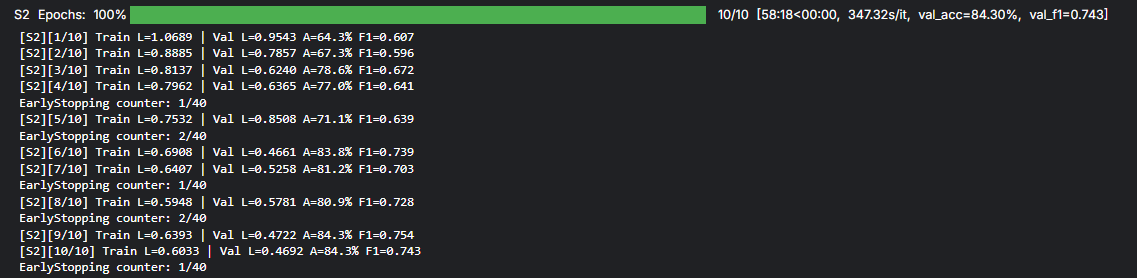

### Calibration: Temperature Scaling for Prediction Reliability
* This cell is vital for ensuring that the model doesn't become overconfident, a common issue after training deep learning models.

* I use the Temperature Scaling technique to calibrate the model's outputs (Logits) post-training.

### Mechanism
* Collect Logits: First, I collect the raw prediction outputs (Logits) from the model on the Validation Data.

* Find the Optimal Temperature (
T 
best
​
 
): I then search for a specific value called the Temperature (
T
) that achieves the lowest Negative Log-Likelihood (NLL). NLL is the best metric for calibration quality.

Calibration: The optimal 
T
 value (usually 
T>1
) is used to smooth out the Logits outputs (
Logits/T
).

* The result is a calibrated model that produces reliable probabilities reflecting the true likelihood of a prediction being correct, all while the model retains the same level of Accuracy. * This step is crucial for increasing confidence in the final model predictions before evaluation or use in an Ensemble.

In [ ]:
import os
import json
import numpy as np
import torch
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm.auto import tqdm

def evaluate_model_after_training(
    model,
    val_loader,
    test_loader,
    save_dir,
    model_filename="best_model.pth",
    class_names=None,
    device=None,
    save_results=True,
    results_filename="evaluation_results.json"
):
   
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
   
    model_path = os.path.join(save_dir, model_filename)
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"✅ Loaded model from: {model_path}")
    else:
        print(f"⚠️ Model file not found: {model_path}")
        print("Evaluating current model state instead...")
    
    model.to(device)
    model.eval()
    
 
    def logits_to_preds(logits):
        return logits.argmax(1)
    
 
    def evaluate(loader, loader_name):
        y_true, y_logits = [], []
        
        with torch.no_grad():
            for xb, yb , _ in tqdm(loader, desc=f"Evaluating {loader_name}", leave=False):
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
           
                
                with torch.amp.autocast(device_type='cuda', enabled=(device.type == 'cuda')):
                    logits = model(xb)
                
                y_true.append(yb.cpu().numpy())
                y_logits.append(logits.cpu().numpy())
        
        y_true = np.concatenate(y_true)
        y_logits = np.concatenate(y_logits)
        y_hat = logits_to_preds(y_logits)
      
        acc = accuracy_score(y_true, y_hat)
        f1 = f1_score(y_true, y_hat, average='macro')
        
     
        print(f"\n🏁 {loader_name} Results:")
        print(f"Accuracy: {acc*100:.2f}%")
        print(f"F1 Score (macro): {f1:.4f}")
        
        # طباعة تقرير التصنيف
        if class_names is not None:
            print("\nClassification Report:")
            print(classification_report(y_true, y_hat, target_names=class_names, digits=3))
        
        return {
            "y_true": y_true,
            "y_logits": y_logits,
            "y_pred": y_hat,
            "accuracy": acc,
            "f1_score": f1
        }
    
 
    val_results = evaluate(val_loader, "Validation")
    test_results = evaluate(test_loader, "Test")
    

    final_results = {
        "validation": {
            "accuracy": val_results["accuracy"],
            "f1_score": val_results["f1_score"]
        },
        "test": {
            "accuracy": test_results["accuracy"],
            "f1_score": test_results["f1_score"]
        },
        "model_path": model_path if os.path.exists(model_path) else "Not found"
    }
    

    if save_results:
        results_path = os.path.join(save_dir, results_filename)
        with open(results_path, 'w') as f:
            json.dump(final_results, f, indent=4)
        print(f"\n Results saved to: {results_path}")
    
    return final_results

The primary function of this cell is to load the best model saved during training and then run it on the Validation and Test datasets to generate the final performance metrics and reports.

1. Model Loading and Preparation
I first search for the best saved weights file (e.g., best_model.pth).

These weights are loaded into the model, ensuring that I am evaluating the model that achieved the best performance and not just the last state it reached.

2. Execution of Evaluation (Inference)
The model is switched to evaluation mode (model.eval()), which deactivates Dropout and dynamic Batch Normalization layers.

Validation and Test data are passed through the model to collect the True Labels and the Logits (raw predictions).

3. Calculation of Key Metrics
Based on the Logits, the final predictions (argmax) are calculated.

The key metrics that reflect overall performance are calculated:

Accuracy: The percentage of correct predictions.

Macro F1-Score: This metric is often more crucial than Accuracy in cases of class imbalance, as it takes the average F1 across all classes, ensuring that rare classes are not ignored.

4. Classification Report Generation
The classification_report function from scikit-learn (sklearn) is used to print a detailed report.

This report shows the model's performance (Precision, Recall, F1-Score) for each individual class, which allows me to understand which classes the model is still struggling to classify.

In [ ]:

print("Evaluating original model...")
original_results = evaluate_model_after_training(
    model=model,
    val_loader=val_loader,
    test_loader=test_loader,
    save_dir=save_directory,
    model_filename="model_s2_best_f1.pth",
    class_names=CLASSES,
    device=device
)

# تنظيف DataLoader
del val_loader
del test_loader
torch.cuda.empty_cache()  